In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO1d
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders
import numpy as np
from timeit import default_timer
import torch.nn.functional as F

device = 'cpu'

In [2]:
# Subsampling rate
sampling_rate = 3
ntrain = 1000
ntest = 100
batch_size = 10


In [3]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
        positional_encoding=True
)

Loading test db at resolution 32 with 50 samples and batch-size=32


In [4]:
train_loader, test_loader, test_data = get_dataloaders('data/burgers_data_R10.mat', ntrain, ntest, batch_size, sampling_rate)

In [5]:
model = TFNO1d(n_modes_height=(16), hidden_channels=32, projection_channels=64,
             in_channels = 2, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 47745 parameters.


In [6]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [7]:
l2loss = LpLoss(d=2, p=2)

eval_losses={'l2': l2loss}

# Training parameters
epochs = 20
batch_size = 20
learning_rate = 0.001
step_size = 50   # weight-decay step size
gamma = 0.5      # weight-decay rate

In [8]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y= sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-4.6638, Train-MSE-0.0242, Train-L2-0.0238, Test-L2-0.0082
Epoch-1, Time-4.7041, Train-MSE-0.0029, Train-L2-0.0103, Test-L2-0.0098
Epoch-2, Time-3.2045, Train-MSE-0.0028, Train-L2-0.0103, Test-L2-0.0086
Epoch-3, Time-2.9199, Train-MSE-0.0011, Train-L2-0.0065, Test-L2-0.0042
Epoch-4, Time-2.9392, Train-MSE-0.0012, Train-L2-0.0066, Test-L2-0.0036
Epoch-5, Time-4.9432, Train-MSE-0.0012, Train-L2-0.0066, Test-L2-0.0085
Epoch-6, Time-5.5322, Train-MSE-0.0013, Train-L2-0.0072, Test-L2-0.0054
Epoch-7, Time-5.3734, Train-MSE-0.0007, Train-L2-0.0052, Test-L2-0.0043
Epoch-8, Time-5.5295, Train-MSE-0.0008, Train-L2-0.0056, Test-L2-0.0083
Epoch-9, Time-6.5511, Train-MSE-0.0009, Train-L2-0.0058, Test-L2-0.0061
Epoch-10, Time-5.6673, Train-MSE-0.0005, Train-L2-0.0044, Test-L2-0.0039
Epoch-11, Time-5.5442, Train-MSE-0.0006, Train-L2-0.0048, Test-L2-0.0058
Epoch-12, Time-5.2289, Train-MSE-0.0005, Train-L2-0.0043, Test-L2-0.0033
Epoch-13, Time-5.1776, Train-MSE-0.0004, Train-L2-0.0037, Tes

In [9]:
# %%
""" Prediction """
pred = []
test_e = []
with torch.no_grad():
    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y= sample["y"].to(device)
        test_l2 = 0 

        out = model(x)
        test_l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        test_e.append( test_l2/batch_size )
        pred.append( out )
        print("Batch-{}, Test-loss-{:0.6f}".format( index, test_l2/batch_size ))
        index += 1

pred = torch.cat((pred))
test_e = torch.tensor((test_e))  
print('Mean Error:', 100*torch.mean(test_e).numpy())

Batch-0, Test-loss-0.000836
Batch-1, Test-loss-0.000746
Batch-2, Test-loss-0.000760
Batch-3, Test-loss-0.000830
Batch-4, Test-loss-0.000881
Batch-5, Test-loss-0.001136
Batch-6, Test-loss-0.000811
Batch-7, Test-loss-0.001075
Batch-8, Test-loss-0.000735
Batch-9, Test-loss-0.001084
Mean Error: 0.08896499639376998


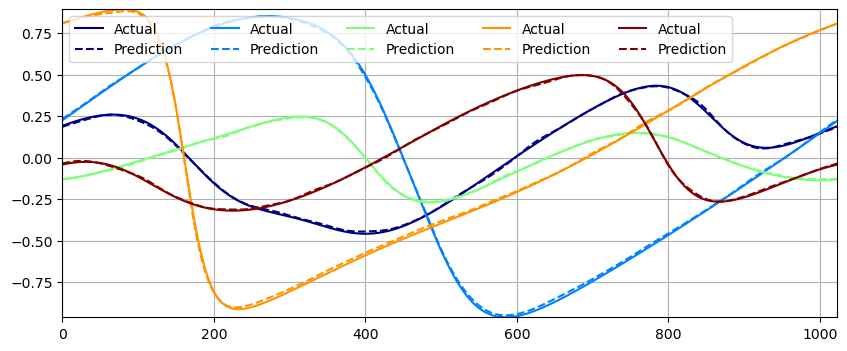

In [10]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
figure7 = plt.figure(figsize = (10, 4))
index = 0
for i in range(y_test.shape[0]):
    if i % 20 == 1:
        plt.plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        plt.plot(pred[i,0].cpu().numpy(), '--', color=colors[index], label='Prediction')
        index += 1
plt.legend(ncol=5)
plt.grid(True)
plt.margins(0)

# PFNO